In [1]:
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.warp import reproject, Resampling
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

# Base paths
project_root = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
s2_root = project_root / "data" / "raw" / "sentinel2"
processed_dir = project_root / "data" / "processed"

print("Project root:", project_root)
print("Sentinel-2 root:", s2_root)
print("Processed dir:", processed_dir)

Project root: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring
Sentinel-2 root: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\raw\sentinel2
Processed dir: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\processed


In [2]:
# Path to RGI 6.0 Region 14 shapefile (same as before)
rgi_path = project_root / "data" / "raw" / "rgi" / "nsidc0770_14.rgi60.SouthAsiaWest" / "14_rgi60_SouthAsiaWest.shp"
rgi = gpd.read_file(rgi_path)
print("Total glaciers in Region 14:", len(rgi))
print("RGI CRS:", rgi.crs)

# Ensure WGS84 lat/lon
if rgi.crs is None:
    rgi = rgi.set_crs(epsg=4326)
elif rgi.crs.to_epsg() != 4326:
    rgi = rgi.to_crs(epsg=4326)

# Gangotri area selection by center lat/lon (same as before)
lat_min, lat_max = 30.5, 31.5
lon_min, lon_max = 78.5, 79.7

rgi_gangotri = rgi[
    (rgi["CenLat"] >= lat_min) & (rgi["CenLat"] <= lat_max) &
    (rgi["CenLon"] >= lon_min) & (rgi["CenLon"] <= lon_max)
].copy()

print("Glaciers in Gangotri region (by center):", len(rgi_gangotri))

# Reproject Gangotri glaciers to UTM zone 44N (EPSG:32644 – Sentinel-2 tile CRS)
target_crs = "EPSG:32644"
rgi_gangotri_utm = rgi_gangotri.to_crs(target_crs)
print("Gangotri CRS (UTM):", rgi_gangotri_utm.crs)

# Bounding box in meters
minx, miny, maxx, maxy = rgi_gangotri_utm.total_bounds
print("Glacier bounds (UTM):", minx, miny, maxx, maxy)

# Add 2 km buffer around glaciers
buffer = 2000  # meters
minx_b, miny_b = minx - buffer, miny - buffer
maxx_b, maxy_b = maxx + buffer, maxy + buffer
print("Buffered bounds (UTM):", minx_b, miny_b, maxx_b, maxy_b)

Total glaciers in Region 14: 27988
RGI CRS: EPSG:4326
Glaciers in Gangotri region (by center): 302
Gangotri CRS (UTM): EPSG:32644
Glacier bounds (UTM): 259315.98630902256 3422929.107673393 375733.4145599046 3487115.964291058
Buffered bounds (UTM): 257315.98630902256 3420929.107673393 377733.4145599046 3489115.964291058


In [3]:
from pathlib import Path

wrapper_2022 = "Gangotri_20221130"  # your wrapper folder
wrapper_path = s2_root / wrapper_2022
print("Wrapper path:", wrapper_path, "exists:", wrapper_path.exists())

# Find SAFE product inside wrapper
safe_products = [p for p in wrapper_path.iterdir() if p.is_dir() and p.name.endswith(".SAFE")]
print("SAFE products inside wrapper:")
for p in safe_products:
    print(" -", p)

if not safe_products:
    raise RuntimeError("No .SAFE folder found inside Gangotri_20221130")

safe_2022 = safe_products[0]
print("\nUsing SAFE product:", safe_2022)

# Find GRANULE and granule subfolder
granule_root = safe_2022 / "GRANULE"
granules = [g for g in granule_root.iterdir() if g.is_dir()]
print("Granule subfolders:")
for g in granules:
    print("  ", g)

if not granules:
    raise RuntimeError("No granule subfolders in GRANULE")

granule = granules[0]
print("\nUsing granule:", granule)

# Find the bands
b02_2022 = next(granule.rglob("*B02_10m.jp2"))
b03_2022 = next(granule.rglob("*B03_10m.jp2"))
b04_2022 = next(granule.rglob("*B04_10m.jp2"))
b08_2022 = next(granule.rglob("*B08_10m.jp2"))
b11_2022 = next(granule.rglob("*B11_20m.jp2"))

print("\nBand paths (2022):")
print("B02:", b02_2022)
print("B03:", b03_2022)
print("B04:", b04_2022)
print("B08:", b08_2022)
print("B11:", b11_2022)

# Open red band to get CRS and transform, and crop window using buffered bounds
with rasterio.open(b04_2022) as red_src:
    s2_crs_2022 = red_src.crs
    print("\n2022 Sentinel-2 CRS:", s2_crs_2022)

    # Build window from UTM bounds
    window_2022 = from_bounds(minx_b, miny_b, maxx_b, maxy_b, transform=red_src.transform)
    window_2022 = window_2022.round_offsets().round_lengths()
    print("Window 2022:", window_2022)

    red_sub_2022 = red_src.read(1, window=window_2022).astype("float32")
    sub_transform_2022 = red_src.window_transform(window_2022)
    sub_crs_2022 = red_src.crs

print("red_sub_2022 shape:", red_sub_2022.shape)

# Read G, B, NIR with same window
with rasterio.open(b03_2022) as g_src:
    green_sub_2022 = g_src.read(1, window=window_2022).astype("float32")

with rasterio.open(b02_2022) as b_src:
    blue_sub_2022 = b_src.read(1, window=window_2022).astype("float32")

with rasterio.open(b08_2022) as nir_src:
    nir_sub_2022 = nir_src.read(1, window=window_2022).astype("float32")

print("green_sub_2022 shape:", green_sub_2022.shape)
print("blue_sub_2022 shape:", blue_sub_2022.shape)
print("nir_sub_2022 shape:", nir_sub_2022.shape)

# Read full SWIR (20 m) and reproject to the 10 m cropped grid
with rasterio.open(b11_2022) as swir_src:
    swir_full_2022 = swir_src.read(1).astype("float32")

    swir_sub_2022 = np.empty_like(red_sub_2022, dtype="float32")

    reproject(
        source=swir_full_2022,
        destination=swir_sub_2022,
        src_transform=swir_src.transform,
        src_crs=swir_src.crs,
        dst_transform=sub_transform_2022,
        dst_crs=sub_crs_2022,
        resampling=Resampling.bilinear,
    )

print("swir_sub_2022 shape:", swir_sub_2022.shape)

Wrapper path: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\raw\sentinel2\Gangotri_20221130 exists: True
SAFE products inside wrapper:
 - c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\raw\sentinel2\Gangotri_20221130\S2A_MSIL2A_20221130T053201_N0510_R105_T44RLV_20240802T222929.SAFE

Using SAFE product: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\raw\sentinel2\Gangotri_20221130\S2A_MSIL2A_20221130T053201_N0510_R105_T44RLV_20240802T222929.SAFE
Granule subfolders:
   c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\raw\sentinel2\Gangotri_20221130\S2A_MSIL2A_20221130T053201_N0510_R105_T44RLV_20240802T222929.SAFE\GRANULE\L2A_T44RLV_A038855_20221130T053159

Using granule: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\raw\sentinel2\Gangotri_20221130\S2A_MSIL2A_20221130T053201_N0510_R105_T44RLV_20240802T222929.SAFE\GRANULE\L2A_T44RLV_A038855_20221130T053159

Band paths (2022):
B02: c:\Users\shriv\

multiband_2022 shape: (6819, 7773, 5)
Saved 2022 multiband array to: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\processed\gangotri_multiband_20221130.npy


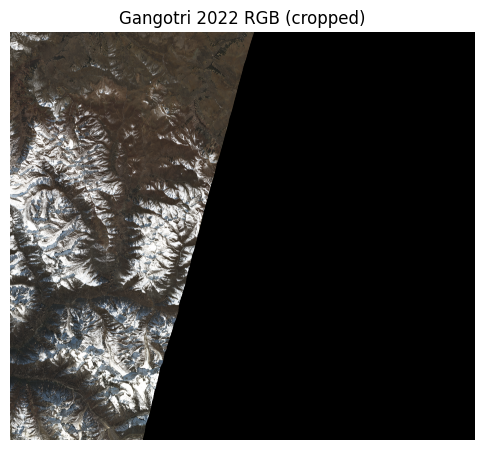

In [4]:
# Stack [R, G, B, NIR, SWIR], scale to [0, 1]
multiband_2022 = np.stack(
    [
        red_sub_2022 / 10000.0,
        green_sub_2022 / 10000.0,
        blue_sub_2022 / 10000.0,
        nir_sub_2022 / 10000.0,
        swir_sub_2022 / 10000.0,
    ],
    axis=-1,  # (H, W, 5)
)

multiband_2022 = np.clip(multiband_2022, 0, 1)
print("multiband_2022 shape:", multiband_2022.shape)

processed_dir.mkdir(parents=True, exist_ok=True)
out_path_2022 = processed_dir / "gangotri_multiband_20221130.npy"
np.save(out_path_2022, multiband_2022.astype("float32"))

print("Saved 2022 multiband array to:", out_path_2022)

# Quick visual check (RGB)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(multiband_2022[..., :3])
ax.set_title("Gangotri 2022 RGB (cropped)")
ax.axis("off")
plt.show()

In [5]:
# Load both years
mb_2018 = np.load(processed_dir / "gangotri_multiband_20181029.npy")   # (H, W, 5)
mb_2022 = np.load(processed_dir / "gangotri_multiband_20221130.npy")   # (H, W, 5)

print("2018 multiband:", mb_2018.shape, mb_2018.dtype)
print("2022 multiband:", mb_2022.shape, mb_2022.dtype)

2018 multiband: (6819, 7773, 5) float32
2022 multiband: (6819, 7773, 5) float32


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=1):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(128, 256)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(64, 32)

        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.down3(self.pool2(x2))
        x4 = self.down4(self.pool3(x3))
        x5 = self.bottleneck(self.pool4(x4))

        x = self.up4(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv4(x)

        x = self.up3(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv3(x)

        x = self.up2(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv2(x)

        x = self.up1(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv1(x)

        return self.out_conv(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet(in_channels=5, out_channels=1).to(device)

model_path = processed_dir / "unet_gangotri_5band.pth"
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("Loaded model weights from:", model_path)

Using device: cpu
Loaded model weights from: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\processed\unet_gangotri_5band.pth


In [7]:
def infer_full_image(multiband, model, device, patch_size=128, stride=128):
    """
    multiband: (H, W, 5) array in [0,1]
    returns: prob_map (H, W) with glacier probability
    """
    model.eval()
    H, W, C = multiband.shape

    # Pad to multiples of patch_size
    pad_h = ((H - 1) // patch_size + 1) * patch_size
    pad_w = ((W - 1) // patch_size + 1) * patch_size

    pad_mb = np.zeros((pad_h, pad_w, C), dtype=np.float32)
    pad_mb[:H, :W, :] = multiband

    prob_map = np.zeros((pad_h, pad_w), dtype=np.float32)
    count_map = np.zeros((pad_h, pad_w), dtype=np.float32)

    for y in range(0, pad_h - patch_size + 1, stride):
        for x in range(0, pad_w - patch_size + 1, stride):
            patch = pad_mb[y:y+patch_size, x:x+patch_size, :]  # (ps, ps, 5)
            # (HWC) -> (1, C, H, W)
            patch_t = torch.from_numpy(patch).permute(2, 0, 1).unsqueeze(0).to(device)

            with torch.no_grad():
                logits = model(patch_t)
                probs = torch.sigmoid(logits)[0, 0].cpu().numpy()  # (ps, ps)

            prob_map[y:y+patch_size, x:x+patch_size] += probs
            count_map[y:y+patch_size, x:x+patch_size] += 1.0

    # Average overlapping predictions
    prob_map /= np.maximum(count_map, 1e-6)

    # Crop back to original size
    prob_map = prob_map[:H, :W]
    return prob_map

In [8]:
print("Running inference for 2018...")
prob_2018 = infer_full_image(mb_2018, model, device, patch_size=128, stride=128)
print("2018 prob_2018 shape:", prob_2018.shape)

print("Running inference for 2022...")
prob_2022 = infer_full_image(mb_2022, model, device, patch_size=128, stride=128)
print("2022 prob_2022 shape:", prob_2022.shape)

# Save probability maps for reuse
np.save(processed_dir / "gangotri_prob_20181029.npy", prob_2018.astype("float32"))
np.save(processed_dir / "gangotri_prob_20221130.npy", prob_2022.astype("float32"))
print("Saved probability maps.")

Running inference for 2018...
2018 prob_2018 shape: (6819, 7773)
Running inference for 2022...
2022 prob_2022 shape: (6819, 7773)
Saved probability maps.


In [14]:
from sklearn.metrics import confusion_matrix

def iou_vs_rgi(prob, rgi_mask, thr):
    pred = (prob > thr).astype("uint8")
    y_true = rgi_mask.ravel()
    y_pred = pred.ravel()
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    union = tp + fp + fn
    return tp / union if union > 0 else 0.0

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
print("IoU(2018 prediction vs RGI) for different thresholds:")
best_thr = None
best_iou = -1

for thr in thresholds:
    iou = iou_vs_rgi(prob_2018, rgi_mask, thr)
    print(f"  thr={thr:.1f} -> IoU={iou:.3f}")
    if iou > best_iou:
        best_iou = iou
        best_thr = thr

print(f"Best threshold on 2018 vs RGI: {best_thr:.2f} with IoU={best_iou:.3f}")

IoU(2018 prediction vs RGI) for different thresholds:
  thr=0.3 -> IoU=0.048
  thr=0.4 -> IoU=0.051
  thr=0.5 -> IoU=0.057
  thr=0.6 -> IoU=0.078
  thr=0.7 -> IoU=0.005
  thr=0.8 -> IoU=0.000
Best threshold on 2018 vs RGI: 0.60 with IoU=0.078


In [15]:
thr = best_thr  # from previous cell

mask_pred_2018 = (prob_2018 > thr).astype("uint8")
mask_pred_2022 = (prob_2022 > thr).astype("uint8")

valid_glacier = (rgi_mask == 1)

pix18_in_rgi = np.logical_and(mask_pred_2018 == 1, valid_glacier).sum()
pix22_in_rgi = np.logical_and(mask_pred_2022 == 1, valid_glacier).sum()

pixel_area_km2 = 1e-4
area18_in_rgi = pix18_in_rgi * pixel_area_km2
area22_in_rgi = pix22_in_rgi * pixel_area_km2
delta_in_rgi  = area18_in_rgi - area22_in_rgi

print(f"Using thr={thr:.2f} and RGI mask:")
print(f"2018 predicted glacier area: {area18_in_rgi:.2f} km²")
print(f"2022 predicted glacier area: {area22_in_rgi:.2f} km²")
print(f"Change 2018→2022: {delta_in_rgi:.2f} km² "
      f"({100 * delta_in_rgi / max(area18_in_rgi, 1e-6):.1f}% of 2018)")

Using thr=0.60 and RGI mask:
2018 predicted glacier area: 33.83 km²
2022 predicted glacier area: 27.09 km²
Change 2018→2022: 6.74 km² (19.9% of 2018)


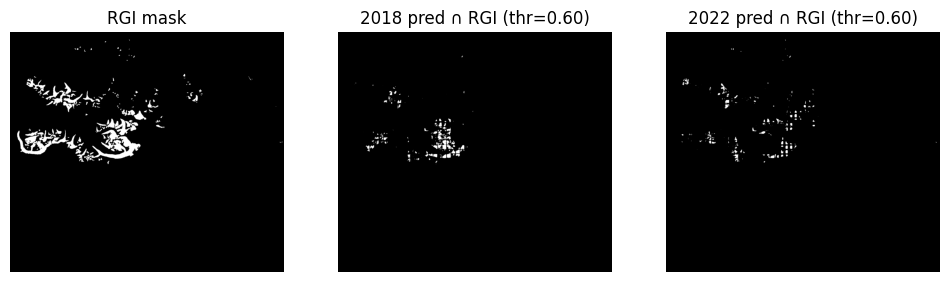

In [16]:
mask18_rgi = np.logical_and(mask_pred_2018 == 1, valid_glacier).astype("uint8")
mask22_rgi = np.logical_and(mask_pred_2022 == 1, valid_glacier).astype("uint8")

step = 4
rgi_small   = rgi_mask[::step, ::step]
m18_small   = mask18_rgi[::step, ::step]
m22_small   = mask22_rgi[::step, ::step]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(rgi_small, cmap="gray"); ax[0].set_title("RGI mask"); ax[0].axis("off")
ax[1].imshow(m18_small, cmap="gray"); ax[1].set_title(f"2018 pred ∩ RGI (thr={thr:.2f})"); ax[1].axis("off")
ax[2].imshow(m22_small, cmap="gray"); ax[2].set_title(f"2022 pred ∩ RGI (thr={thr:.2f})"); ax[2].axis("off")
plt.show()

In [11]:
from rasterio.features import rasterize

# We already have rgi_gangotri_utm and buffered bounds (minx_b, miny_b, maxx_b, maxy_b)
# Now get the 2018 red band transform and shape for this crop

wrapper_2018 = "Gangotri_20181024"
wrap18_path = s2_root / wrapper_2018

safe18_list = [p for p in wrap18_path.iterdir() if p.is_dir() and p.name.endswith(".SAFE")]
print("2018 SAFE products:", safe18_list)
if not safe18_list:
    raise RuntimeError("No 2018 SAFE folder found under Gangotri_20181024")

safe18 = safe18_list[0]
granule_root18 = safe18 / "GRANULE"
granules18 = [g for g in granule_root18.iterdir() if g.is_dir()]
granule18 = granules18[0]
print("Using 2018 granule:", granule18)

b04_2018 = next(granule18.rglob("*B04_10m.jp2"))
print("2018 B04:", b04_2018)

with rasterio.open(b04_2018) as red18_src:
    window18 = from_bounds(minx_b, miny_b, maxx_b, maxy_b, transform=red18_src.transform)
    window18 = window18.round_offsets().round_lengths()
    red18_sub = red18_src.read(1, window=window18)
    transform18 = red18_src.window_transform(window18)

print("red18_sub shape:", red18_sub.shape)

# Should match mb_2018.shape[:2]
print("mb_2018 shape[:2]:", mb_2018.shape[:2])

# Rasterize RGI Gangotri polygons onto this grid
rgi_shapes = [(geom, 1) for geom in rgi_gangotri_utm.geometry]

rgi_mask = rasterize(
    rgi_shapes,
    out_shape=red18_sub.shape,
    transform=transform18,
    fill=0,
    dtype="uint8",
)

print("RGI mask shape:", rgi_mask.shape, "glacier pixels:", rgi_mask.sum())

2018 SAFE products: [WindowsPath('c:/Users/shriv/OneDrive/Desktop/himalayan-glacier-monitoring/data/raw/sentinel2/Gangotri_20181024/S2A_MSIL2A_20181029T051921_N0500_R062_T44RLV_20230705T145456.SAFE')]
Using 2018 granule: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\raw\sentinel2\Gangotri_20181024\S2A_MSIL2A_20181029T051921_N0500_R062_T44RLV_20230705T145456.SAFE\GRANULE\L2A_T44RLV_A017505_20181029T052731
2018 B04: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\raw\sentinel2\Gangotri_20181024\S2A_MSIL2A_20181029T051921_N0500_R062_T44RLV_20230705T145456.SAFE\GRANULE\L2A_T44RLV_A017505_20181029T052731\IMG_DATA\R10m\T44RLV_20181029T051921_B04_10m.jp2
red18_sub shape: (6819, 7773)
mb_2018 shape[:2]: (6819, 7773)
RGI mask shape: (6819, 7773) glacier pixels: 1693029


In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

project_root = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
fig_dir = project_root / "reports" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

print("Figure directory:", fig_dir)

Figure directory: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\reports\figures


In [ ]:
#  it just aligns RGI with your probability maps and creates binary masks.
# RGI (Randolph Glacier Inventory)
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.windows import from_bounds
from rasterio.features import rasterize
from pathlib import Path

# ---- Paths ----
project_root = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
processed_dir = project_root / "data" / "processed"
s2_root = project_root / "data" / "raw" / "sentinel2"

print("Project root:", project_root)
print("Processed dir:", processed_dir)

# ---- Load probability maps (already saved earlier) ----
prob_2018 = np.load(processed_dir / "gangotri_prob_20181029.npy")
prob_2022 = np.load(processed_dir / "gangotri_prob_20221130.npy")
print("prob_2018:", prob_2018.shape, prob_2018.dtype)
print("prob_2022:", prob_2022.shape, prob_2022.dtype)

# ---- Load RGI and subset to Gangotri ----
rgi_path = project_root / "data" / "raw" / "rgi" / "nsidc0770_14.rgi60.SouthAsiaWest" / "14_rgi60_SouthAsiaWest.shp"
rgi = gpd.read_file(rgi_path)
print("Total glaciers in Region 14:", len(rgi))
print("RGI CRS:", rgi.crs)

# ensure lat/lon
if rgi.crs is None:
    rgi = rgi.set_crs(epsg=4326)
elif rgi.crs.to_epsg() != 4326:
    rgi = rgi.to_crs(epsg=4326)

lat_min, lat_max = 30.5, 31.5
lon_min, lon_max = 78.5, 79.7

rgi_gangotri = rgi[
    (rgi["CenLat"] >= lat_min) & (rgi["CenLat"] <= lat_max) &
    (rgi["CenLon"] >= lon_min) & (rgi["CenLon"] <= lon_max)
].copy()
print("Glaciers in Gangotri subset:", len(rgi_gangotri))

# project to UTM 44N
rgi_gangotri_utm = rgi_gangotri.to_crs("EPSG:32644")
minx, miny, maxx, maxy = rgi_gangotri_utm.total_bounds
buffer = 2000  # m
minx_b, miny_b = minx - buffer, miny - buffer
maxx_b, maxy_b = maxx + buffer, maxy + buffer
print("Buffered bounds (UTM):", minx_b, miny_b, maxx_b, maxy_b)

# ---- Build 2018 transform/shape for this crop ----
wrapper_2018 = "Gangotri_20181024"
wrap18_path = s2_root / wrapper_2018

safe18_list = [p for p in wrap18_path.iterdir() if p.is_dir() and p.name.endswith(".SAFE")]
print("2018 SAFE products:", safe18_list)
if not safe18_list:
    raise RuntimeError("No 2018 SAFE folder found under Gangotri_20181024")

safe18 = safe18_list[0]
granule_root18 = safe18 / "GRANULE"
granules18 = [g for g in granule_root18.iterdir() if g.is_dir()]
granule18 = granules18[0]
print("Using 2018 granule:", granule18)

b04_2018 = next(granule18.rglob("*B04_10m.jp2"))
print("2018 B04:", b04_2018)

with rasterio.open(b04_2018) as red18_src:
    window18 = from_bounds(minx_b, miny_b, maxx_b, maxy_b, transform=red18_src.transform)
    window18 = window18.round_offsets().round_lengths()
    red18_sub = red18_src.read(1, window=window18)
    transform18 = red18_src.window_transform(window18)

print("red18_sub shape:", red18_sub.shape)

# should match prob_2018 shape
print("prob_2018 shape:", prob_2018.shape)

# ---- Rasterize RGI onto this grid to get rgi_mask ----
rgi_shapes = [(geom, 1) for geom in rgi_gangotri_utm.geometry]

rgi_mask = rasterize(
    rgi_shapes,
    out_shape=red18_sub.shape,
    transform=transform18,
    fill=0,
    dtype="uint8",
)

print("RGI mask shape:", rgi_mask.shape, "glacier pixels:", rgi_mask.sum())

# ---- Threshold probabilities with thr=0.6 ----
thr = 0.6
mask_pred_2018 = (prob_2018 > thr).astype("uint8")
mask_pred_2022 = (prob_2022 > thr).astype("uint8")

valid_glacier = (rgi_mask == 1)
mask18_rgi = np.logical_and(mask_pred_2018 == 1, valid_glacier).astype("uint8")
mask22_rgi = np.logical_and(mask_pred_2022 == 1, valid_glacier).astype("uint8")

print("mask18_rgi glacier pixels:", mask18_rgi.sum())
print("mask22_rgi glacier pixels:", mask22_rgi.sum())

Project root: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring
Processed dir: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\processed
prob_2018: (6819, 7773) float32
prob_2022: (6819, 7773) float32
Total glaciers in Region 14: 27988
RGI CRS: EPSG:4326
Glaciers in Gangotri subset: 302
Buffered bounds (UTM): 257315.98630902256 3420929.107673393 377733.4145599046 3489115.964291058
2018 SAFE products: [WindowsPath('c:/Users/shriv/OneDrive/Desktop/himalayan-glacier-monitoring/data/raw/sentinel2/Gangotri_20181024/S2A_MSIL2A_20181029T051921_N0500_R062_T44RLV_20230705T145456.SAFE')]
Using 2018 granule: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\raw\sentinel2\Gangotri_20181024\S2A_MSIL2A_20181029T051921_N0500_R062_T44RLV_20230705T145456.SAFE\GRANULE\L2A_T44RLV_A017505_20181029T052731
2018 B04: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\data\raw\sentinel2\Gangotri_20181024\S2A_MSIL2A_20181029T051921_N0500_R062_T44RLV_202307

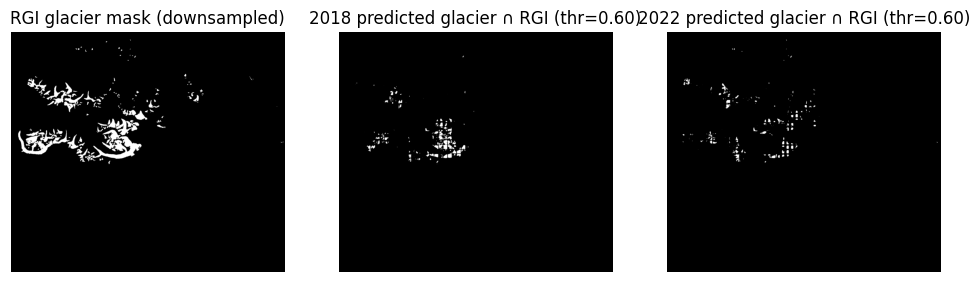

Saved: c:\Users\shriv\OneDrive\Desktop\himalayan-glacier-monitoring\reports\figures\fig_rgi_pred_2018_2022.png


In [ ]:
# for making smaller copies
step = 4  # downsample for display

rgi_small = rgi_mask[::step, ::step]
m18_small = mask18_rgi[::step, ::step]
m22_small = mask22_rgi[::step, ::step]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(rgi_small, cmap="gray")
ax[0].set_title("RGI glacier mask (downsampled)")
ax[0].axis("off")

ax[1].imshow(m18_small, cmap="gray")
ax[1].set_title("2018 predicted glacier ∩ RGI (thr=0.60)")
ax[1].axis("off")

ax[2].imshow(m22_small, cmap="gray")
ax[2].set_title("2022 predicted glacier ∩ RGI (thr=0.60)")
ax[2].axis("off")

from pathlib import Path
project_root = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
fig_dir = project_root / "reports" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)
out_path = fig_dir / "fig_rgi_pred_2018_2022.png"

plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", out_path)